# COVID Case Count Estimation
#### Kartik Chugh - July 8, 2020

Key to the spread of coronavirus has been cryptic transmission, whereby asymptomatic carriers pass it along unknowingly to others. The US, with its tepid testing and tracing measures and low governmental preparedness, is thought to have been particularly afflicted by this phenomenon. 

 <img src="china-data.png" />

> Chart from <a href="https://jamanetwork.com/journals/jama/fullarticle/2762130">Journal of the American Medical Association</a>, pertaining to the Hubei province of China. Orange bars indicate medical diagnoses of the coronavirus, while gray bars indicate onset of symptoms as reported by patients.

In this project, we derive estimates for true case counts for the United States from January to present, using a technique espoused in a [Medium article](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca) that went viral in March.

In [50]:
import numpy as np
import pandas as pd
import matplotlib as mpl

from pandas import Timestamp, Series
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.3f}'.format})
%config InlineBackend.figure_format = 'svg'
register_matplotlib_converters()

## Estimating Doubling Time

We begin by pulling live data from the [COVID Tracking Project](https://covidtracking.com/api), which has made their datasets available through a free API. We're interested in two main statistics: daily deaths due to the virus, and cumulative confirmed case count.

In [51]:
url = 'https://covidtracking.com/api/v1/us/daily.csv'

# loads data
df = pd.read_csv(url, 
            usecols=['date', 'positive', 'deathIncrease'], 
            parse_dates=['date'], 
            index_col=['date']).sort_index().iloc[1:]

time = df.index
confirmed = df['positive']
deathsDaily = df['deathIncrease']

Next, we use the daily growth in confirmed cases to compute estimates of _doubling time_: at the current rate, how many days it would take for cases to double. For this, we use

$$ T_{double} = \frac{ln(2)}{ln(\frac{c_t}{c_{t-1}})} $$ 

where $ c_t $ is the confirmed case count on a given day and $ c_{t-1} $ on the day prior.

In [52]:
def doublingTime(a, b):
    return np.log(2)/np.log(b/a) if (a != b) else np.nan # avoids division by zero

# computes doubling times
doubling = np.full(confirmed.shape, np.nan)
for t in range(1, len(doubling)):
    doubling[t] = doublingTime(confirmed[t-1], confirmed[t])

# stores in dataframe
doubling_orig = pd.DataFrame(doubling, index=time, columns=['doubling time'])

However, case reports are known to be erratic due to testing backlogs and a variety of other factors. We apply a Gaussian filter to de-noise the data, as we can assume that the real world process is not nearly as stochastic as the reporting. 

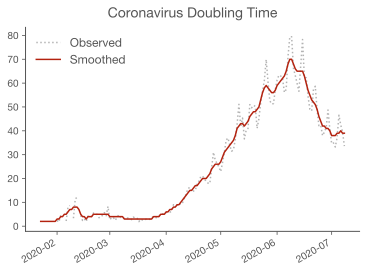

In [53]:
doubling_smooth = doubling_orig.rolling(13,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

plt.plot(doubling_orig, c='k', ls=':', alpha=.3)
plt.plot(doubling_smooth)
plt.gcf().autofmt_xdate()
plt.legend(['Observed', 'Smoothed'])
plt.title('Coronavirus Doubling Time')
plt.show()

Intuitively, the time it takes for coronavirus cases to double rises with social distancing and falls in its absence.

## Backpropagating First Mortalities

Recall the chart at the top of this page, displaying the time lag between onset of coronavirus symptoms (assessed retroactively) and official diagnosis from a medical official. While onset figures are more accurate than confirmed case counts at representing the virus' spread over time, they still undercount true cases, as asymptomatic carriers fly under the radar. But there is a not-so-silent indicator of disease: death.

While apparent mortality in the US is 3-5%, this figure is considered an overstimate due to cases not reported. Researchers peg the true mortality rate at close to 1%. And the other thing we know is how often it takes between contracting the virus and dying: [17 days](https://midasnetwork.us/covid-19/), on average.

In [54]:
MORTALITY = 0.01
MORTALITY_LAG = 17

From the "mortality lag", we can take the date of the first coronavirus deaths in the US and estimate when the victims contracted the virus ($t_0$).

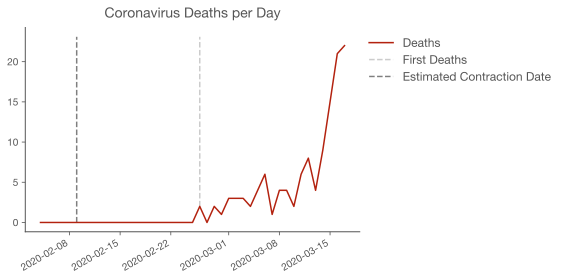

In [55]:
t_init = deathsDaily.ne(0).idxmax()
d_init = deathsDaily[t_init]
t0 = t_init - timedelta(days=MORTALITY_LAG)

plt.plot(deathsDaily[t0-timedelta(days=5):t_init+timedelta(days=20)], label='Deaths')
max_y=plt.gca().get_ylim()[1]
plt.vlines(t_init, d_init, max_y, ls='--', alpha=0.2, label='First Deaths')
plt.vlines(t0, 0, max_y, ls='--', alpha=0.5, label='Estimated Contraction Date')
plt.gcf().autofmt_xdate()
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1))
plt.title('Coronavirus Deaths per Day')
plt.show()

Using the mortality rate of 1%, we can say that if 2 people died from the coronavirus on Feb 26, around 200 people had the disease 17 days earlier. 

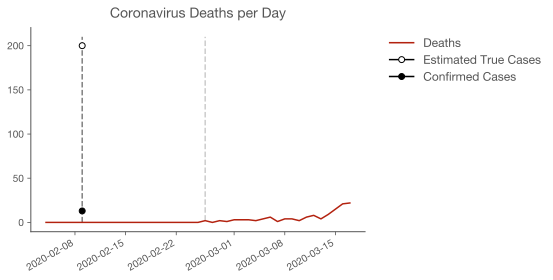

In [56]:
c0 = d_init * 1/MORTALITY

plt.plot(deathsDaily[t0-timedelta(days=5):t_init+timedelta(days=20)], label='Deaths')
plt.plot(t0,c0, marker='o', mfc='w', mec='k', c='k', label='Estimated True Cases') 
plt.plot(t0,confirmed[t0], marker='o', mfc='k', mec='k', c='k', label='Confirmed Cases') 
max_y=plt.gca().get_ylim()[1]
plt.vlines(t_init, d_init, max_y, ls='--', alpha=0.2)
plt.vlines(t0, 0, max_y, ls='--', alpha=0.5)
plt.gcf().autofmt_xdate()
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1))
plt.title('Coronavirus Deaths per Day')
plt.show()

Compare this to the known case count of 2 at the time. By early Feburary, we had **roughly the same number of true cases as we had confirmed cases a full month later**. 

From Feb 9, we can propagate forward the true growth of the virus using the doubling time data generated above, as well as estimate cases prior to that date.

## Modeling True Cases

For every day $ t_i $ after $ t_0 $, case count should grow from the previous day's by a factor of 
$2^{1/{T_i}}$, where $ T_i $ is that day's doubling time. In a similar fashion, days before $ t_0 $ should grow up to ≈200 cases exponentially.

In [57]:
c = np.full(confirmed.shape, c0)

# after feb 9
for t in range((t0-time[0]).days, len(c)):
    db = doubling_smooth['doubling time'][t]
    c[t] = c[t-1] * 2**(1/db)

# before feb 9
for t in range((t0-time[0]).days, -1, -1):
    db = doubling_smooth['doubling time'][t]
    c[t] = c[t+1] / 2**(1/db)
    
estimated = pd.DataFrame(c, index=time)

Confirmed Cases: 3042503
Estimated Cases: 26761974


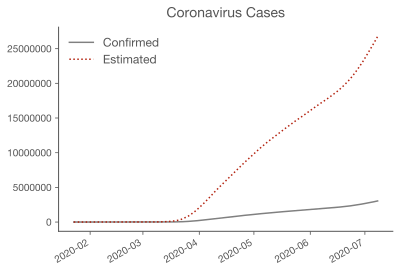

In [58]:
plt.plot(confirmed, c='gray', label='Confirmed')
plt.plot(estimated, ls=':', label='Estimated')
plt.legend()
plt.title('Coronavirus Cases')
plt.gcf().autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

print(f"Confirmed Cases: {confirmed[-1]}")
print(f"Estimated Cases: {c[-1]:.0f}")

As the scientific community has warned us all along, **the difference between known and unknown cases is staggering**.

We can use the data to zoom in on data from March, when the pandemic sent markets crashing to 4-year lows. Even as the virus began to grip the nation, case growth was accelerating beyond what could be seen.

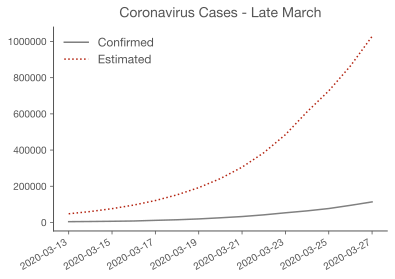

In [59]:
plt.plot(confirmed[50:65], c='gray', label='Confirmed')
plt.plot(estimated[50:65], ls=':', label='Estimated')
plt.legend()
plt.title('Coronavirus Cases - Late March')
plt.gcf().autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

Importantly, we can also go back in time to get a sense of the pandemic its early stages.

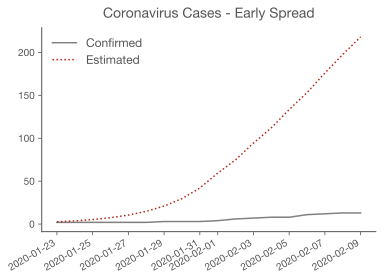

In [65]:
plt.plot(confirmed[0:18], c='gray', label='Confirmed')
plt.plot(estimated[0:18], ls=':', label='Estimated')
plt.legend()
plt.title('Coronavirus Cases - Early Spread')
plt.gcf().autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

According to the model, **the US may have had its first case as early as Jan 20**, at the same time China was scrambling to contain the outbreak in Wuhan. 

Note that this is a rough estimate, not an exact figure—the same goes for all other model data. However, the model does lend itself to a general insight: that **the coronavirus spread across the country far earlier** than we thought and that **current cases vastly exceed reported figures**.